# Minimal Detectable Deformation w.r.t. Detectability Power
@author: Max Felius

This notebook will take a subset from a dataset and determine the MDD at each point.

In [23]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from decouple import config
import pandas as pd
import os, sys, time, re
import datetime
import scipy

In [2]:
#import Dataset
path = config('subset1')
filename = config('name_subset2')

data = pd.read_csv(os.path.join(path,filename))

In [3]:
def get_delta_day(epochs):
    dates = list(map(lambda x: datetime.datetime.strptime(x,'d_%Y%m%d'),epochs))
    start_date = dates[0]
    dates_days = np.array(list(map(lambda x: (x-start_date).days,dates)))

    return dates_days, start_date

In [4]:
def linear_model(epochs,data):
    '''
    Function creating the linear model for detect arcs behaving anomalous
    '''
    
    #creating time vector
    delta_days, start_day = get_delta_day(epochs)
    
    #pre-allocate space for the output variables
    a = []
    b = []
    sigma_ehat = []
    
    for i in range(len(data)):
        '''
        Loop creating a linear model per row
        '''
        
        #setting up the system of equations
        y = np.array(data[epochs].iloc[i])
        A = np.array((delta_days,np.ones([len(delta_days)])))
        
        #stochastic matrix
        W = np.eye((len(y)))
        
        #compute solutions
        invW = np.linalg.inv(W)
        Qxhat = np.linalg.inv(A @ invW @ A.T)
        xhat = Qxhat @ A @ invW @ y
        
        yhat = A.T @ xhat
        ehat = y - yhat
        
        #compute the standard deviation of the noise of an arc
        sigma_ehat_out = np.sqrt((np.sum((ehat - np.mean(ehat))**2))/len(y))
        
        #saving the data
        a.append(xhat[0])
        b.append(xhat[1])
        sigma_ehat.append(sigma_ehat_out)
    
    return a, b, sigma_ehat
    

In [5]:
#determine sigma per point
#filter out the epochs
filter_option = re.compile(r'd_\d{8}')
epochs = list(filter(lambda x: filter_option.match(x) != None, list(data)))

a,b,sigma_lin_model = linear_model(epochs,data)

# data = data.join(pd.DataFrame(data_sigma,columns=['Sigma']))

In [6]:
def solve(m1,m2,std1,std2):
    a = 1/(2*std1**2) - 1/(2*std2**2)
    b = m2/(std2**2) - m1/(std1**2)
    c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
    return np.roots([a,b,c])

In [7]:
#NO: assume a detection power of 80%, what is the MDD
#Assume a MDD of 1 cm, what will be the detection power?
# m1 = 0
# std1 = sigma
# std2 = sigma
dec_pow = []
m1 = 0
m2 = 0.01 # 1cm

for item in sigma_lin_model:
    result = solve(m1,m2,item,item)
    r = result[0]
    area = 1-(norm.cdf(r,m2,item) + (1-norm.cdf(r,m1,item)))
    dec_pow.append(area*100)

The sigma (noise) of each point is based on a linear model which is fitted on the deformation time-series. 

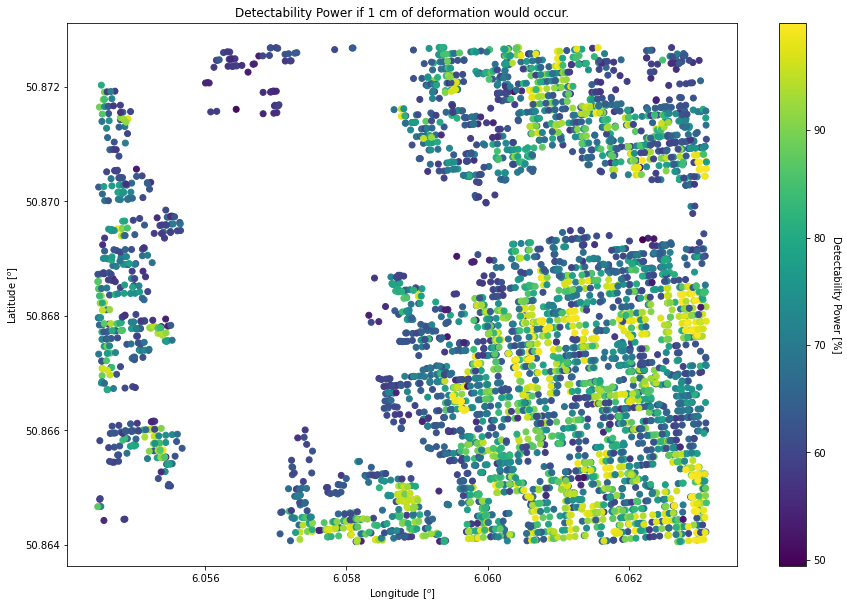

In [8]:
plt.figure(figsize=(15,10))
p = plt.scatter(data['pnt_lon'],data['pnt_lat'],c=dec_pow)
clb = plt.colorbar(p)
clb.set_label("Detectability Power [%]",rotation=270,labelpad=15)

plt.title('Detectability Power if 1 cm of deformation would occur.')
plt.xlabel('Longitude [$^o$]')
plt.ylabel('Latitude [$^o$]');

## With a detectability Power of x percent, what will be the minimal observable deformation
bal

In [44]:
def solve(m1,m2,std1,std2):
    a = 1/(2*std1**2) - 1/(2*std2**2)
    b = m2/(std2**2) - m1/(std1**2)
    c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
    return np.roots([a,b,c])

def function(m2,decpow):
    m1 = 0
    item = 0.003
    result = solve(m1,m2,item,item)
    r = result[0]
    return 1-(norm.cdf(r,m2,item) + (1-norm.cdf(r,m1,item))) - decpow

def function2(m2,input_var):
    sigma, decpow = input_var
    m1 = 0
#     item = 0.003
    result = solve(m1,m2,sigma,sigma)
    r = result[0]
    return 1-(norm.cdf(r,m2,sigma) + (1-norm.cdf(r,m1,sigma))) - decpow

In [63]:
sigma = 0.003414727361437336

function2(0.008754,[sigma,0.8]) # thus a sigma of 0.003m and decpow of 80% the MDD is 0.00769 m

8.74393980463406e-05

In [67]:
MDD = []
decpow = 0.8

for item in sigma_lin_model:
    input_var = [item,decpow]
    MDD.append(100*scipy.optimize.fsolve(function2,item,input_var))

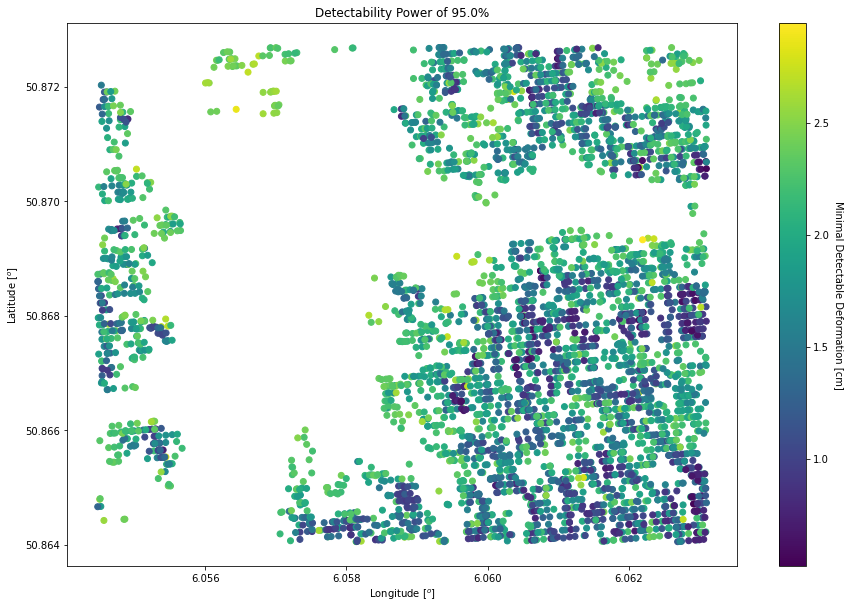

In [70]:
MDD = []
decpow = 0.95

for item in sigma_lin_model:
    input_var = [item,decpow]
    MDD.append(100*scipy.optimize.fsolve(function2,item,input_var))

plt.figure(figsize=(15,10))
p = plt.scatter(data['pnt_lon'],data['pnt_lat'],c=MDD)
clb = plt.colorbar(p)
clb.set_label("Minimal Detectable Deformation [cm]",rotation=270,labelpad=15)

plt.title(f'Detectability Power of {decpow*100}%')
plt.xlabel('Longitude [$^o$]')
plt.ylabel('Latitude [$^o$]');

## Discusion
- Linear model is used, but is this the correct model?
- Do episodes of very noise signal have a large influence on the sigma determination process?